In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import modules.deep_model as DeepModel
import modules.model as Model 
import tensorflow as tf
import warnings
import numpy as np
import os

warnings.filterwarnings('ignore')

## Công việc 2.2 (Tiếp theo):
* Ở phần này, chúng ta sẽ xây dựng một **Comment sentiment model** bằng LSTM.
* Chúng ta biết rằng hạn chế của RNN là nó không thể lưu trữ các thông tin trong dài hạn - RNN tiến hành lưu trữ các thông tin mà nó học được từ chuổi vào các **hidden state** nhưng khi chuổi đầu vào quá dài - nó sẽ không thể giữ lại các thông tin này do vấn đề **gradient-vanishing** [tiêu biến gradient] trong quá trình backpropagation:<br>
  ![](./images/14.png)
* LSTM ra đời để khắc phục gradient-vanishing bằng một cấu trúc đặc biệt gọi là **gate**. Gate sẽ lưu các thông tin của chuổi lại đồng thời nó quản lí được thông tin nào nên xóa khỏi bộ nhớ và thông tin nào cần giữ.
* Giả sử chúng ta có câu: **Giao hàng nhanh**. Với RNN nó dễ dàng dự đoán được comment này thuộc class positive. Nhưng giả sử ta có câu dài hơn: **Giao hàng chậm "nhưng" hàng đẹp - cảm ơn shop**. Thì câu hỏi đặt ra là làm sao RNN có thể lưu trữ các thông tin trước từ **nhưng** là negative word và phía sau là positive word. RNN sẽ không thể lưu trữ các thông tin này do vấn đề vanishing-gradient. Nhưng với LSTM nó sẽ giảm bớt hiện tượng này nhờ sử dụng một cấu trúc là LSTM cell. <br>
  ![](./images/15.png)
* Lúc này, mỗi LSTM cell sẽ chứa ba gate lần lượt là:
  * **Input gate**: quyết định thông tin nào cần được thêm vào từ chuổi đầu vào.
  * **Output gate**: quyết định thông tin nào cần được lưu trữ
  * **Forget gate**: thông tin nào cần được loại bỏ.
  
  ![](./images/16.png)

* Ở RNN, một hidden state được sử dụng cho hai mục đích là lưu trữ thông tin và đưa ra dự đoán. Tuy nhiên ở LSTM nó tách hiddent state thành hai phần là:
  * **Cell state**: đây là nơi lưu giữ thông tin.
  * **Hidden state**: dùng cho việc dự đoán.
* Cell state và hidden state chia sẻ thông tin lẫn nhau. Như hình trên ta thấy đầu vào sau khi đi qua hidden state $\rightarrow$ qua các gate $\rightarrow$ đến cell state.

Bây giờ chúng ta sẽ tiến hành xây dựng một **Comment sentiment model** sử dụng LSTM của TensorFlow.

Load dữ liệu training.

In [3]:
X_train, y_train = Model.loadData("./data/data/train")
X_train = X_train.fillna("")

X_test, y_test = Model.loadData("./data/data/test")
X_test = X_test.fillna("")

display(X_train, y_train)
display(X_test, y_test)


,comment,nomalized_comment,emoji_decode
0,"Chất liệu bình thường, áo rộng so v...",bình_thường áo_rộng với xin đổi bả...,
1,Đúng với mô tả:đúng\nChất liệu:nỉ\n...,đúng nỉ đỏ xám bo tay lệch nhiều thừa,raised_hand
2,Đúng với mô tả:ko đúng lắm còn bị ra...,đúng lắm rách nhiều kiến riêng ổn m...,
3,10dd,,
4,hàng k đúng mẫu đặt mua,hàng không đúng mẫu đặt mua,
...,...,...,...
21741,Chất liệu:vải\nĐúng với mô tả:đúng\...,vải đúng ghi áo rất đẹp rất cuốn_hú...,
21742,Mk thấy áo k được đẹp lắm \n2 lớp n...,mình thấy áo không được đẹp lắm lơ...,
21743,Màu sắc:trắng\nChất liệu:gió\nĐúng ...,trắng gió giống không đẹp hợp giá ti...,
21744,GIẢM GIÁ KHỦNG - MUA SẮM LIỀN TAY\n ...,giảm_giá khủng mua_sắm liền_tay sale sa...,house_with_garden heart heart diamonds diamond...


,label
0,0
1,0
2,0
3,1
4,0
...,...
21741,1
21742,0
21743,0
21744,1


,comment,nomalized_comment,emoji_decode
0,Hàng nhận về khác vs ảnh,hàng nhận khác với ảnh,
1,(hình ảnh mang tính chất nhận xu) áo đ...,áo đẹp chất vải mặc không nóng xíu l...,
2,Chất liệu:tạm ổn\nMàu sắc:chuẩn\nĐ...,tạm ổn chuẩn ok cá sơ_chế xong bạn c...,
3,Đúng với mô tả:dungd dày dặn cầm nạ...,dày_dặn cầm nặng_tay be xịn,
4,Đã nhận . 1 áo k đúng như đã đặt ..😩,nhận áo không đúng đặt,weary
...,...,...,...
9315,Màu sắc:ok\nĐúng với mô tả:duong may n...,ok may nỗi ok,
9316,Màu sắc:kh giống hình\nChất liệu:vả...,giống hình vải mỏng không size l tay_áo...,
9317,Đúng với mô tả:ko đúng với mô tả\nCh...,vải xốp màu trắng đẹp đúng form nên mua,
9318,"Màu sắc:xám\nChất liệu:...\n\nEo, tui ...",xám eo tôi đặt áo mong_muốn tay_áo_dà...,smiling_face_with_tear smiling_face_with_tear ...


,label
0,0
1,1
2,1
3,1
4,0
...,...
9315,0
9316,0
9317,0
9318,0


Ở đây, em đã viết gọn tất cả các tính năng của một LSTM model vào một object là `SentimentLSTM` nằm trong file `deep_model.py`, về ý tưởng của em như sau:
  * **Bước 1**: Dữ liệu training ở đây là các comment đã qua bước tiền xử lí ở feature `normalize_comment` - ta bỏ qua không cần xử lí N-Grams cho feature này.
  * **Bước 2**: Ta sử dụng cơ chế Tokenizer do TensorFlow cung cấp, object `Tokenizer` của TensorFlow yêu cầu một hyper-pamrameter là `num_words` - tức số lượng từ tối đa ta muốn tokenize, ở đây nếu để bằng `None`, `Tokenizer` sẽ được tự động tính. Cuối cùng `Tokenizer` sẽ lưu các comment dưới dạng mảng chứa các index của từ, với index của từ phổ biến nhất là 1.
  * **Bước 3**: Ta sử dụng phương thức `pad_sequences()` của TensorFlow - phương thức này sẽ dựa vào thuộc tính `maxlen` để đưa toàn bộ các comment về cùng một độ dài, các comment nào có chiều dài lớn sẽ được cắt bớt. Các comment ngắn hơn sẽ được thay thế bằng giá trị 0.
  * **Bước 4**: Ta sẽ định nghĩa kiến trúc của model trong `SentimentLSTM._defineModel()`. Ở đây, để tiện cho quá trình HyperParams Optimization, ta sẽ để thuộc tính `optimizer` linh động dựa trên tham vào truyền vào của hàm. Tiếp theo, ở output ta sử dụng 2 neuron để lưu giá trị của xác suất để dự đoán comment đó ở lần lượt hai class là negative và positive, ta sử dụng loss function là **binary cross-entropy** và action function **softmax** cho output layer này.
  * **Bước 5**: Để ta có thể kiểm soát được liệu model có bị overfitting trong quá trính training không, nếu có ta có thể dừng quá trình training lại. Tại đây ta sử dụng object `CheckPoint` do TensorFlow cung cấp, object này sẽ theo dõi qua trình training và dựa vào thông số trên loss function mà ta chỉ định là trên train hay validation data để tiến hành lưu lại **weights set** của model tại thời điểm loss value này thấp nhất, ở đây em sẽ sử dụng 10% dữ liệu training làm validation và chỉ định validation loss để tránh overfitting.

Code dưới đây ta sẽ định nghĩa một hyperparams set cho model. Ở đây `num_words` là `None` để cho TensorFlow tự tính toán, ta sử dụng 10 neuron cho LSTM layer và dropout regularixation có xác suất để một neuron bị tắt ở layer này là 20%.

Sau đó ta sẽ cho in `summary` để xem tổng số weight của model và trực quan hóa kiến trúc của model.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          477600    
                                                                 
 lstm (LSTM)                 (None, 10)                4440      
                                                                 
 output (Dense)              (None, 2)                 22        
                                                                 
Total params: 482,062
Trainable params: 482,062
Non-trainable params: 0
_________________________________________________________________


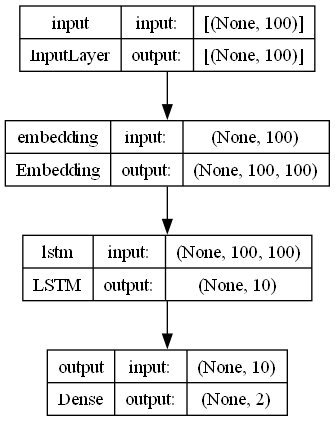

In [9]:
hyperparameters_1 = {
    'pX': X_train['nomalized_comment'],  # <== giữ nguyên dạng Series (text)
    'py': y_train,
    'pnum_words': None,
    'pseq_length': 100,
    'pno_units': 10,
    'pdropout': 0.2,
    'pbatch_size': 32,
    'pepochs': 10,
    'psave_weights': './models/lstm_model_comments_1.h5'
}

model_1 = DeepModel.SentimentLSTM()
model_1.define(**hyperparameters_1)
model_1.model.summary()
plot_model(model_1.model, to_file='./images/lstm_model_comments_1.png', show_shapes=True, show_layer_names=True)

Bây giờ ta tiến hành training model.

In [11]:
model_1.fit(**hyperparameters_1)

Epoch 1/10
612/612 [==============================] - 44s 68ms/step - loss: 0.4170 - accuracy: 0.8219 - val_loss: 0.3322 - val_accuracy: 0.8630
Epoch 2/10
612/612 [==============================] - 42s 69ms/step - loss: 0.3096 - accuracy: 0.8735 - val_loss: 0.3207 - val_accuracy: 0.8667
Epoch 3/10
612/612 [==============================] - 41s 67ms/step - loss: 0.2821 - accuracy: 0.8848 - val_loss: 0.3208 - val_accuracy: 0.8703
Epoch 4/10
612/612 [==============================] - 41s 68ms/step - loss: 0.2626 - accuracy: 0.8937 - val_loss: 0.3221 - val_accuracy: 0.8690
Epoch 5/10
612/612 [==============================] - 44s 72ms/step - loss: 0.2480 - accuracy: 0.8996 - val_loss: 0.3292 - val_accuracy: 0.8680
Epoch 6/10
612/612 [==============================] - 44s 72ms/step - loss: 0.2346 - accuracy: 0.9053 - val_loss: 0.3375 - val_accuracy: 0.8662
Epoch 7/10
612/612 [==============================] - 46s 76ms/step - loss: 0.2233 - accuracy: 0.9106 - val_loss: 0.3429 - val_accuracy:

In [15]:
%load_ext tensorboard
%tensorboard --logdir ./tb_log_sentiment --port 6006

Reusing TensorBoard on port 6006 (pid 10424), started 0:48:02 ago. (Use '!kill 10424' to kill it.)

> **Nhận xét**:
> * Hai biểu đồ trên lần lượt thể hiện giá trị accuracy và loss value qua 10 epoch với đường màu xanh dương là của **validation data** và  là của **training data** được vẽ bằng TensorBoard. Có thể thấy kể từ epoch thứ 2 trở đi thì loss value có xu hướng đi xuống ở training data và đi lên ở valudation. Lúc này nhờ cơ thế CheckPoint của TensorFlow mà các weight tại thời điểm này được lưu lại và ta có thể kiểm tra sau này.

Tiếp theo, ta sẽ tokenizer cho test data để tiến hành đánh giá trên test data.

In [19]:
prediction_1 = model_1.predict(X_test['nomalized_comment'])
prediction_1

292/292 [==============================] - 3s 9ms/step


,input,output_proba,output_class
0,hàng nhận khác với ảnh,"(0.99931586, 0.00068412407)",0
1,áo đẹp chất vải mặc không nóng xíu l...,"(1.9561148e-06, 0.9999981)",1
2,tạm ổn chuẩn ok cá sơ_chế xong bạn c...,"(0.00013257691, 0.99986744)",1
3,dày_dặn cầm nặng_tay be xịn,"(0.0018044217, 0.9981956)",1
4,nhận áo không đúng đặt,"(0.99020267, 0.009797305)",0
...,...,...,...
9315,ok may nỗi ok,"(0.18794872, 0.81205124)",1
9316,giống hình vải mỏng không size l tay_áo...,"(0.9999504, 4.958703e-05)",0
9317,vải xốp màu trắng đẹp đúng form nên mua,"(0.2039462, 0.7960538)",1
9318,xám eo tôi đặt áo mong_muốn tay_áo_dà...,"(0.99992, 8.003754e-05)",0


              precision    recall  f1-score   support

    Negative       0.86      0.85      0.86      4703
    Positive       0.85      0.86      0.85      4617

    accuracy                           0.86      9320
   macro avg       0.86      0.86      0.86      9320
weighted avg       0.86      0.86      0.86      9320



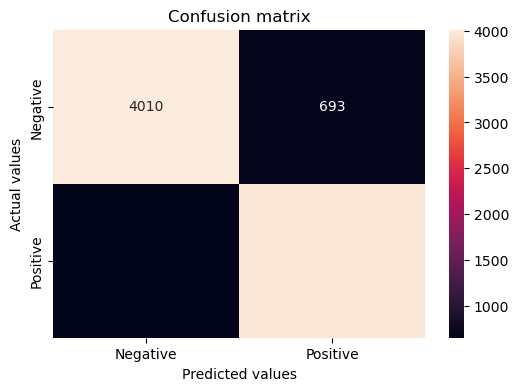

In [21]:
Model.confusionMatrix(y_test, prediction_1['output_class'])

> **Nhận xét**:
> * Ta có thể thấy rõ ràng rằng dù độ chính xác của model LSTM khá cao hơn 86%, với việc để các hyper-params cho TensorFlow tự quyết thì model có khả năng dự đoán cân bằng trên cả hai class là negative và postive, ta không cần phải kiểm tra lại bằng ROC-AUC.

Do ta có áp dụng checkpoint trong model để lưu lại các bộ tham số tốt nhất trong quá trình training, ta có thể lấy bộ tham số mà có validation loss thấp nhất để update trọng số cho model.

In [25]:
model_uw_1 = DeepModel.SentimentLSTM()
model_uw_1.define(**hyperparameters_1)
model_uw_1.model.load_weights("./models/lstm_model_comments_1/weights/02-0.320742.h5")

In [29]:
prediction_uw_1 = model_uw_1.predict(X_test['nomalized_comment'])
prediction_uw_1

292/292 [==============================] - 3s 9ms/step


,input,output_proba,output_class
0,hàng nhận khác với ảnh,"(0.99756914, 0.002430812)",0
1,áo đẹp chất vải mặc không nóng xíu l...,"(0.00069467945, 0.99930537)",1
2,tạm ổn chuẩn ok cá sơ_chế xong bạn c...,"(0.0082001425, 0.9917998)",1
3,dày_dặn cầm nặng_tay be xịn,"(0.004782529, 0.99521744)",1
4,nhận áo không đúng đặt,"(0.9953831, 0.004616857)",0
...,...,...,...
9315,ok may nỗi ok,"(0.09072669, 0.90927327)",1
9316,giống hình vải mỏng không size l tay_áo...,"(0.9991843, 0.00081570994)",0
9317,vải xốp màu trắng đẹp đúng form nên mua,"(0.13546914, 0.86453086)",1
9318,xám eo tôi đặt áo mong_muốn tay_áo_dà...,"(0.9932201, 0.006779932)",0


              precision    recall  f1-score   support

    Negative       0.85      0.87      0.86      4703
    Positive       0.86      0.84      0.85      4617

    accuracy                           0.85      9320
   macro avg       0.86      0.85      0.85      9320
weighted avg       0.86      0.85      0.85      9320



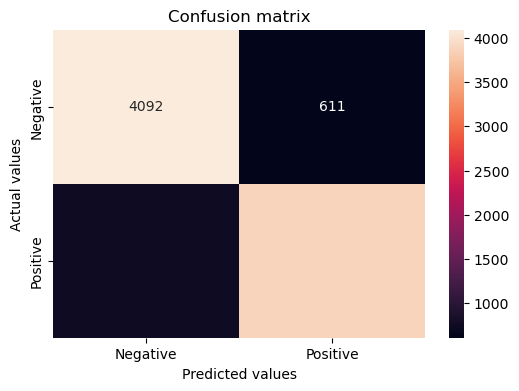

In [31]:
Model.confusionMatrix(y_test, prediction_uw_1['output_class'])

> **Nhận xét**:
> * Ta thấy rằng nếu nhìn vào các chỉ số như **precision**, **recall** và **F1-score** thì model được update bởi weight ở tại epoch thứ hai này hoạt động cho hiệu suất thậm chí tốt hơn một ít dù chỉ mới trải qua 2 epoch.

Ta sẽ đào tạo một model thứ hai với các hyper-params là `num_word` và `maxlen` lần lượt là 3000 và 100, ở project hai ta đã tính được toàn bộ data của ta có khoảng loanh quanh 3000 từ và các comment hay có độ dài là 100 và sử dụng 15 neuron ở LSTM layer.

Ta sẽ định nghĩa model sau đó cho training, dự đoán và đánh giá.

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          477600    
                                                                 
 lstm (LSTM)                 (None, 15)                6960      
                                                                 
 output (Dense)              (None, 2)                 32        
                                                                 
Total params: 484,592
Trainable params: 484,592
Non-trainable params: 0
_________________________________________________________________


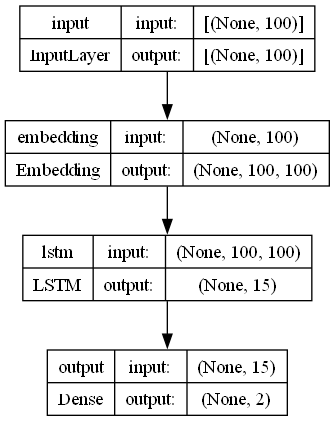

In [35]:
hyperparameters_2 = {
    'pX': X_train['nomalized_comment'], 
    'py': y_train, 
    'pnum_words': 3000, 
    'pseq_length': 100,
    'pno_units': 15, 
    'pdropout': 0.3, 
    'pbatch_size': 32, 
    'pepochs': 10, 
    'psave_weights': './models/lstm_model_comments_2.h5'
}

model_2 = DeepModel.SentimentLSTM()
model_2.define(**hyperparameters_2)
model_2.model.summary()
plot_model(model_2.model, to_file='./images/lstm_model_comments_2.png', show_shapes=True, show_layer_names=True)

In [39]:
model_2.fit(**hyperparameters_2)

Epoch 1/10
612/612 [==============================] - 35s 57ms/step - loss: 0.3296 - accuracy: 0.8636 - val_loss: 0.3150 - val_accuracy: 0.8671
Epoch 2/10
612/612 [==============================] - 40s 66ms/step - loss: 0.2939 - accuracy: 0.8773 - val_loss: 0.3126 - val_accuracy: 0.8713
Epoch 3/10
612/612 [==============================] - 44s 72ms/step - loss: 0.2742 - accuracy: 0.8867 - val_loss: 0.3165 - val_accuracy: 0.8680
Epoch 4/10
612/612 [==============================] - 47s 77ms/step - loss: 0.2582 - accuracy: 0.8911 - val_loss: 0.3241 - val_accuracy: 0.8717
Epoch 5/10
612/612 [==============================] - 50s 82ms/step - loss: 0.2461 - accuracy: 0.8976 - val_loss: 0.3374 - val_accuracy: 0.8694
Epoch 6/10
612/612 [==============================] - 48s 78ms/step - loss: 0.2349 - accuracy: 0.9050 - val_loss: 0.3473 - val_accuracy: 0.8634
Epoch 7/10
612/612 [==============================] - 46s 76ms/step - loss: 0.2239 - accuracy: 0.9091 - val_loss: 0.3464 - val_accuracy:

In [41]:
%load_ext tensorboard
%tensorboard --logdir ./tb_log_sentiment --port 6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 10424), started 1:12:43 ago. (Use '!kill 10424' to kill it.)

> **Nhận xét**:
> * Với việc ta tự định nghĩa hyper-params set, kết quả đem lại không tốt hơn so với model 1. Có thể thấy rõ accuracy và loss validation trên training data (đường màu xám) và validation data (đường màu cam) bắt đầu khác nhau và khoảng cách khác biệt là lớn - không được ổn định bằng model 1.
> * Ta có thể update weight tại epocg thứ 2 xem có cải thiện hơn không.

In [43]:
prediction_2 = model_2.predict(X_test['nomalized_comment'])
prediction_2

292/292 [==============================] - 3s 9ms/step


,input,output_proba,output_class
0,hàng nhận khác với ảnh,"(0.9929395, 0.0070605655)",0
1,áo đẹp chất vải mặc không nóng xíu l...,"(3.2749608e-07, 0.99999964)",1
2,tạm ổn chuẩn ok cá sơ_chế xong bạn c...,"(3.4492885e-05, 0.99996555)",1
3,dày_dặn cầm nặng_tay be xịn,"(0.00014547573, 0.99985445)",1
4,nhận áo không đúng đặt,"(0.99622154, 0.0037784097)",0
...,...,...,...
9315,ok may nỗi ok,"(0.13968933, 0.8603107)",1
9316,giống hình vải mỏng không size l tay_áo...,"(0.9995427, 0.000457331)",0
9317,vải xốp màu trắng đẹp đúng form nên mua,"(0.25301027, 0.7469897)",1
9318,xám eo tôi đặt áo mong_muốn tay_áo_dà...,"(0.998604, 0.001396034)",0


              precision    recall  f1-score   support

    Negative       0.86      0.85      0.86      4703
    Positive       0.85      0.86      0.86      4617

    accuracy                           0.86      9320
   macro avg       0.86      0.86      0.86      9320
weighted avg       0.86      0.86      0.86      9320



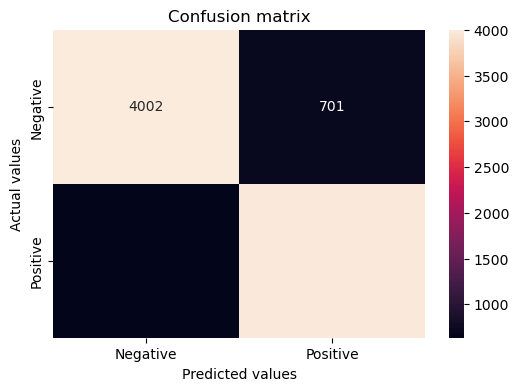

In [45]:
Model.confusionMatrix(y_test, prediction_2['output_class'])

> **Nhận xét**:
> * Độ chính xác của model 2 này là 86 phần trăm, giống với model 1.
> * Nhưng ta nên đặt câu hỏi vì sao đã qua 2 model có kiến trúc khác nhau rất nhiều nhưng độ chính xác vẫn loanh quanh 85, 86%.

In [47]:
model_uw_2 = DeepModel.SentimentLSTM()
model_uw_2.define(**hyperparameters_2)
model_uw_2.model.load_weights("./models/lstm_model_comments_2/weights/02-0.312602.h5")

In [49]:
prediction_uw_2 = model_uw_2.predict(X_test['nomalized_comment'])
prediction_uw_2

292/292 [==============================] - 3s 9ms/step


,input,output_proba,output_class
0,hàng nhận khác với ảnh,"(0.9965036, 0.0034964655)",0
1,áo đẹp chất vải mặc không nóng xíu l...,"(0.00014218244, 0.9998578)",1
2,tạm ổn chuẩn ok cá sơ_chế xong bạn c...,"(0.04159521, 0.95840484)",1
3,dày_dặn cầm nặng_tay be xịn,"(0.003350051, 0.9966499)",1
4,nhận áo không đúng đặt,"(0.9946688, 0.0053311707)",0
...,...,...,...
9315,ok may nỗi ok,"(0.10211441, 0.89788556)",1
9316,giống hình vải mỏng không size l tay_áo...,"(0.9997825, 0.0002175625)",0
9317,vải xốp màu trắng đẹp đúng form nên mua,"(0.10964305, 0.8903569)",1
9318,xám eo tôi đặt áo mong_muốn tay_áo_dà...,"(0.9885852, 0.011414803)",0


              precision    recall  f1-score   support

    Negative       0.87      0.84      0.86      4703
    Positive       0.84      0.88      0.86      4617

    accuracy                           0.86      9320
   macro avg       0.86      0.86      0.86      9320
weighted avg       0.86      0.86      0.86      9320



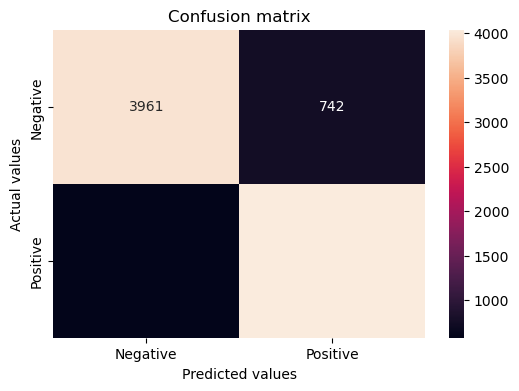

In [51]:
Model.confusionMatrix(y_test, prediction_uw_2['output_class'])

> **Nhận xét**:
> * Độ chính xác của model 2 lúc này đã giảm đi.
> * Nếu ta đào tạo quá 10 epoch thì càng ngàng bị overfitting, nhưng nếu ta thay đổi kiến trúc của model thì độ chính xác luôn loanh quanh 86, 87%. Như vậy đây có phải là độ chính xác tối đa mà model LSTM có thể đạt được hoặc là do chính data của ta bị variance error do có sự chồng chéo data giữa nagative và postive ở các comment 3 sao.

Bây giờ ta sẽ lưu lại các model này thành file `*.h5` và các vectorizer tương ứng thành file `*.pickle`.

In [53]:
model_1.save("./models/lstm_model_comments_1/lstm_model_comments_1.h5", "./models/lstm_model_comments_1/lstm_tokenizer_comments_1.pickle")
model_uw_1.save("./models/lstm_model_comments_1/lstm_model_comments_uw_1.h5", "./models/lstm_model_comments_1/lstm_tokenizer_comments_uw_1.pickle")

(<keras.preprocessing.text.Tokenizer object at 0x0000013A2FF2E050>, 100) has been saved at ./models/lstm_model_comments_1/lstm_tokenizer_comments_1.pickle.
📢 Model has been saved at ./models/lstm_model_comments_1/lstm_model_comments_1.h5 - Tokenizer has been saved at ./models/lstm_model_comments_1/lstm_tokenizer_comments_1.pickle.
(<keras.preprocessing.text.Tokenizer object at 0x0000013A3E59A610>, 100) has been saved at ./models/lstm_model_comments_1/lstm_tokenizer_comments_uw_1.pickle.
📢 Model has been saved at ./models/lstm_model_comments_1/lstm_model_comments_uw_1.h5 - Tokenizer has been saved at ./models/lstm_model_comments_1/lstm_tokenizer_comments_uw_1.pickle.


In [55]:
model_2.save("./models/lstm_model_comments_2/lstm_model_comments_2.h5", "./models/lstm_model_comments_2/lstm_tokenizer_comments_2.pickle")
model_uw_2.save("./models/lstm_model_comments_2/lstm_model_comments_uw_2.h5", "./models/lstm_model_comments_2/lstm_tokenizer_comments_uw_2.pickle")

(<keras.preprocessing.text.Tokenizer object at 0x0000013A4119D790>, 100) has been saved at ./models/lstm_model_comments_2/lstm_tokenizer_comments_2.pickle.
📢 Model has been saved at ./models/lstm_model_comments_2/lstm_model_comments_2.h5 - Tokenizer has been saved at ./models/lstm_model_comments_2/lstm_tokenizer_comments_2.pickle.
(<keras.preprocessing.text.Tokenizer object at 0x0000013A49686190>, 100) has been saved at ./models/lstm_model_comments_2/lstm_tokenizer_comments_uw_2.pickle.
📢 Model has been saved at ./models/lstm_model_comments_2/lstm_model_comments_uw_2.h5 - Tokenizer has been saved at ./models/lstm_model_comments_2/lstm_tokenizer_comments_uw_2.pickle.
